<a href="https://colab.research.google.com/github/lochieh19798/Data-analysis/blob/main/Figure2mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edition control

In [32]:
!git config --global user.name "lochieh19798"
!git config --global user.email "lochieh19798@gmail.com"

In [33]:
!git clone https://github.com/lochieh19798/data-analysis

fatal: destination path 'data-analysis' already exists and is not an empty directory.


In [34]:
# ╔═╡ Cell 0 ═════════════════════════════════════════════════════════════╗
# If you’re on Colab, install any non-preinstalled libraries:
!pip install -q catboost shap scikit-learn==1.4.2 matplotlib pandas numpy
!pip install -q --upgrade xgboost
!pip install -q shap --no-deps

In [35]:
from xgboost.sklearn import XGBModel
XGBModel.feature_weights = None
print("Patched XGBModel.feature_weights →", XGBModel.feature_weights)

Patched XGBModel.feature_weights → None


In [36]:
# ╔═╡ Cell 1 ═════════════════════════════════════════════════════════════╗
# Imports & global configuration
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.impute import (
    KNNImputer,
    SimpleImputer
    # ← no IterativeImputer here
)
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    ExtraTreesClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 43
plt.style.use("default")


In [37]:
# ╔═╡ Cell 2 – load data & build feature lists with missing‐% report ═════╝
from pathlib import Path
import pandas as pd

# 1. Data‐loading helper (as before)
DATA_PATH = "/content/data-analysis/CRYOANALYSIS.csv"
def load_and_prepare_data(csv_path: str = DATA_PATH) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # (1) Recurrence flags
    df["Survival_time"] = pd.to_numeric(df["Survival_time"], errors="coerce")
    df = df.dropna(subset=["Survival_time", "Recurrence"])
    df["Recurrence_1yr"] = ((df["Survival_time"] <= 365) & (df["Recurrence"] == 1)).astype(int)
    df["Recurrence_2yr"] = ((df["Survival_time"] <= 730) & (df["Recurrence"] == 1)).astype(int)
    # (2) AF type one‐hot
    af_col = "Baseline AF Type(1=paroxysmal, 2=persistent)"
    df["AF_Parox"]   = (df[af_col] == 1).astype(int)
    df["AF_Persist"] = (df[af_col] == 2).astype(int)
    return df

# 2. Load the dataset
DATA_PATH = Path("/content/data-analysis/CRYOANALYSIS.csv")
assert DATA_PATH.exists(), f"{DATA_PATH} not found – upload it first!"
df = load_and_prepare_data(DATA_PATH)

# 3. Feature lists
cont = [
    "age", "BMI",
    "Baseline LVEF", "Baseline LAD", "CHA2DS2VASc score", "CHAD2 score", "AF_time_procedure",
    "Total no of ablation application number", "Mobility question (Baseline)",
    "Self-care question (Baseline)", "Usual activities question (Baseline)",
    "Pain/Discomfort question (Baseline)", "Anxiety/Depression question (Baseline)",
    "Visual analogue score: Your own health state today (Baseline)",
    "Total procedure time: Venous access to last cryoatheter removal (mins)",
    "Total fluoro time (mins)", "Energy duration LSPV", "Coldest Temperature LSPV",
    "Energy duration LIPV", "Coldest Temperature LIPV",
    "Energy duration RSPV", "Coldest temperature RSPV",
    "Energy duration RIPV", "Coldest Temperature RIPV",
    "Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins)",
    "Change in EQ 5D"
    # "Time to isolation LSPV", "Time to isolation LIPV", "Time to isolation RSPV","Time to isolation RIPV",
]

cat = [
    "Sex (F=1, M=0)", "Hypertension", "Diabetes", "HF", "CAD", "stroke",
    "History of TIA", "Subject taking Class I or III AAD at baseline (1=Yes, 0=No)",
    "LSPV isolated", "LIPV PV isolated", "RSPV Isolated", "RIPV isolated",
    "Were all targeted PVs isolated (Investigator)?",
    "AF_Parox", "AF_Persist",
    "CTI ablation",
    "Non-PVI ablation performed",
    "Was subject taking Class I or Class III AAD at procedure discharge?",
    "Mapping/navigational tools: Intracardiac echocardiography (ICE)",
    "Pre Procedural CT",
    "Ensite 3D mapping"
]

TARGET = "Recurrence_2yr"

# 4. Report missing‐value percentages for every feature
all_feats = cont + cat
missing_pct = df[all_feats].isna().mean() * 100
missing_report = (
    missing_pct
      .sort_values(ascending=False)
      .rename("missing_pct")
      .reset_index()
      .rename(columns={"index": "variable"})
)
print("📊 Missing Value Percentage per Feature:")
print(missing_report.to_string(index=False, float_format="%.1f%%"))

# 5. Gentle column check: warn & drop if still missing
missing_cont = [c for c in cont if c not in df.columns]
missing_cat  = [c for c in cat  if c not in df.columns]
if missing_cont or missing_cat:
    print("\n⚠️  WARNING – some expected columns are missing and will be skipped.")
    print("   Missing continuous :", missing_cont)
    print("   Missing categorical:", missing_cat)

cont = [c for c in cont if c in df.columns]
cat  = [c for c in cat  if c in df.columns]

# From here on, the rest of the notebook runs as before...


📊 Missing Value Percentage per Feature:
                                                                                          variable  missing_pct
                                                                                      Baseline LAD        32.7%
                                                                                   Change in EQ 5D        27.0%
                                                            Anxiety/Depression question (Baseline)        25.6%
                                                               Pain/Discomfort question (Baseline)        25.6%
                                                              Usual activities question (Baseline)        25.6%
                                                                     Self-care question (Baseline)        25.6%
                                     Visual analogue score: Your own health state today (Baseline)        25.6%
                                                                

In [38]:
# ╔═╡ Cell 3 – Train vs. Hold-out Split for k-Fold CV ─────────────────────╗
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) (Optional) Sort by date to preserve temporal order
df["ProcedureDate"] = pd.to_datetime(df["ProcedureDate"])
df_sorted = df.sort_values("ProcedureDate")

# 2) Extract feature matrix & target vector
X_all = df_sorted[cont + cat]
y_all = df_sorted[TARGET].astype(int)

# 3) Single stratified split: 80% train, 20% hold-out
X_train, X_hold, y_train, y_hold = train_test_split(
    X_all,
    y_all,
    test_size=0.30,
    stratify=y_all,
    random_state=RANDOM_STATE
)

# 4) Report counts and event rates
print("Split sizes:")
print(f"  • Train:    {len(y_train)} samples")
print(f"  • Hold-out: {len(y_hold)} samples")
print(f"  • Total:    {len(y_train) + len(y_hold)} samples\n")

print("Event rates:")
print(f"  • Overall:    {y_all.mean():.2%}")
print(f"  • Train:      {y_train.mean():.2%}")
print(f"  • Hold-out:   {y_hold.mean():.2%}")


Split sizes:
  • Train:    196 samples
  • Hold-out: 85 samples
  • Total:    281 samples

Event rates:
  • Overall:    19.22%
  • Train:      19.39%
  • Hold-out:   18.82%


In [39]:
# ╔═╡ Cell 4 – Pre-processing pipelines ═══════════════════════════════════╗
# (Make sure to enable the experimental IterativeImputer)
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline           import Pipeline
from sklearn.impute             import IterativeImputer, SimpleImputer
from sklearn.preprocessing      import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose            import ColumnTransformer

# Numeric pipeline: iterative imputation → power transform → scaling
numeric_pipe = Pipeline([
    ("impute", IterativeImputer(random_state=RANDOM_STATE)),
    ("power",  PowerTransformer(method="yeo-johnson")),
    ("scale",  StandardScaler())
])

# Categorical pipeline: fill missing with "Missing" → one-hot encode
categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Full preprocessor: apply to continuous and categorical lists
preprocessor = ColumnTransformer([
    ("num", numeric_pipe,       cont),
    ("cat", categorical_pipe,   cat)
], remainder="drop")


In [40]:
# ╔═╡ Cell 4b – preview IterativeImputer + PowerTransformer on numeric features ═══════╗
import warnings
from sklearn.exceptions import ConvergenceWarning

# (Optionally suppress FutureWarnings or ConvergenceWarnings)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Show missing counts before
num_train = X_train[cont].copy()
print("🔴 Missing before imputation (numeric features):")
print(num_train.isna().sum())

# 2. Fit & transform with your updated numeric_pipe
num_imputed = pd.DataFrame(
    numeric_pipe.fit_transform(num_train),
    columns=cont,
    index=num_train.index
)

# 3. Show missing counts after
print("\n🟢 Missing after IterativeImputer + PowerTransformer:")
print(num_imputed.isna().sum())

# 4. Display first few rows of the transformed DataFrame
display(num_imputed.head())


🔴 Missing before imputation (numeric features):
age                                                                                                    0
BMI                                                                                                    0
Baseline LVEF                                                                                         43
Baseline LAD                                                                                          60
CHA2DS2VASc score                                                                                      0
CHAD2 score                                                                                            0
AF_time_procedure                                                                                     18
Total no of ablation application number                                                                0
Mobility question (Baseline)                                                                          53
Self-ca

,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Mobility question (Baseline),Self-care question (Baseline),...,Energy duration LSPV,Coldest Temperature LSPV,Energy duration LIPV,Coldest Temperature LIPV,Energy duration RSPV,Coldest temperature RSPV,Energy duration RIPV,Coldest Temperature RIPV,Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins),Change in EQ 5D
53,-0.143642,-0.722661,0.268395,-0.762074,2.045987,1.826317,-0.363648,-3.197429,-0.189526,-2.682578,...,0.282618,0.132128,0.098875,0.139005,0.045868,0.018030,0.089029,-0.059204,0.190869,-0.025309
261,-0.231222,-0.258819,-0.180960,-0.146134,-0.546494,-1.141146,0.114058,-0.567480,2.457626,3.493972,...,-0.089241,1.482332,0.149758,-2.044194,-1.157997,1.036712,-1.376756,0.698415,0.768794,2.245141
171,1.506021,0.424727,-1.295082,0.258744,0.823180,1.060053,0.632289,-1.022603,-0.256966,-0.002192,...,-0.089241,0.912888,0.149758,0.649248,-1.157997,0.653098,-1.376756,-1.007067,-0.778156,-1.315557
43,0.831766,0.647479,1.065223,-0.762074,-1.771674,-1.141146,0.737473,0.397831,0.913892,-0.262345,...,1.167674,-0.054859,0.149758,-0.576641,0.242215,0.159568,0.100400,-0.594598,-1.528422,-0.009421
95,0.519909,-0.378178,-1.509968,-0.083268,0.236124,0.345238,-0.524703,-0.093520,-0.256966,-0.002192,...,-0.089241,0.713089,0.149758,-0.459265,-0.034153,-1.280475,0.100400,-1.431506,0.706448,0.167691


In [41]:
# ╔═╡ Cell 4c – preview string-cast → impute → one-hot on categorical features ═══════╗
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import FunctionTransformer, OneHotEncoder
from sklearn.impute            import SimpleImputer
import pandas as pd

# 1) Re-define categorical_pipe to cast → impute → one-hot
categorical_pipe = Pipeline([
    # cast every value to string
    ("to_str",   FunctionTransformer(lambda X: X.astype(str), validate=False)),
    # fill missing with literal "Missing"
    ("impute",   SimpleImputer(strategy="constant", fill_value="Missing")),
    # one-hot encode the strings
    ("onehot",   OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 2. Grab the raw cat columns (with NaNs)
cat_train = X_train[cat].copy()
print("🔴 Missing before imputation (categorical features):")
print(cat_train.isna().sum())

# 3. Fit & transform via the updated pipeline
cat_ohe_array = categorical_pipe.fit_transform(cat_train)

# 4. Turn back into a DataFrame
cat_ohe_cols = categorical_pipe.named_steps["onehot"].get_feature_names_out(cat)
cat_imputed  = pd.DataFrame(cat_ohe_array, columns=cat_ohe_cols, index=cat_train.index)

print("\n🟢 Missing after to_str → SimpleImputer → OneHotEncoder:")
print(cat_imputed.isna().sum().sum(), "total NaNs remaining")

print("\n🖨️ Sample of the imputed one-hot matrix:")
display(cat_imputed.iloc[:, :10].head())


🔴 Missing before imputation (categorical features):
Sex (F=1, M=0)                                                         0
Hypertension                                                           0
Diabetes                                                               0
HF                                                                     0
CAD                                                                    0
stroke                                                                 0
History of TIA                                                         0
Subject taking Class I or III AAD at baseline (1=Yes, 0=No)            8
LSPV isolated                                                          0
LIPV PV isolated                                                       1
RSPV Isolated                                                          1
RIPV isolated                                                          2
Were all targeted PVs isolated (Investigator)?                         7

,"Sex (F=1, M=0)_0","Sex (F=1, M=0)_1",Hypertension_0,Hypertension_1,Diabetes_0,Diabetes_1,HF_0,HF_1,CAD_0,CAD_1
53,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
261,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
171,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
43,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
95,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [42]:
# ╔═╡ Cell 4d – inspect full preprocessed feature space ─══════════════╗
from sklearn.compose import ColumnTransformer

# 1) Re‐build the ColumnTransformer as in Cell 4
ct = ColumnTransformer([
    ("num", numeric_pipe, cont),
    ("cat", categorical_pipe, cat)
], remainder="drop")

# 2) Fit & transform your training set
X_tr_full = ct.fit_transform(X_train)

# 3) Manually assemble the feature names:
#    - numeric features keep their original names
num_features = cont

#    - categorical features come from the OneHotEncoder inside categorical_pipe
cat_ohe_names = categorical_pipe.named_steps["onehot"] \
                     .get_feature_names_out(cat)

#    - combine
feat_names = list(num_features) + list(cat_ohe_names)

# 4) Report
print(f"➡️  Combined train matrix: {X_tr_full.shape[0]} rows × {X_tr_full.shape[1]} cols")
print(f"📦  Total features = {len(feat_names)}")
print("🔍  Example feature names:", feat_names[:10], "…", feat_names[-10:])

# 5) (optional) display the first few rows in a DataFrame
import pandas as pd
df_feats = pd.DataFrame(X_tr_full, columns=feat_names, index=X_train.index)
df_feats.head()


➡️  Combined train matrix: 196 rows × 75 cols
📦  Total features = 75
🔍  Example feature names: ['age', 'BMI', 'Baseline LVEF', 'Baseline LAD', 'CHA2DS2VASc score', 'CHAD2 score', 'AF_time_procedure', 'Total no of ablation application number', 'Mobility question (Baseline)', 'Self-care question (Baseline)'] … ['Was subject taking Class I or Class III AAD at procedure discharge?_0', 'Was subject taking Class I or Class III AAD at procedure discharge?_1', 'Mapping/navigational tools: Intracardiac echocardiography (ICE)_0', 'Mapping/navigational tools: Intracardiac echocardiography (ICE)_1', 'Pre Procedural CT_0.0', 'Pre Procedural CT_1.0', 'Pre Procedural CT_nan', 'Ensite 3D mapping_0.0', 'Ensite 3D mapping_1.0', 'Ensite 3D mapping_nan']


,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Mobility question (Baseline),Self-care question (Baseline),...,Was subject taking Class I or Class III AAD at procedure discharge?_0,Was subject taking Class I or Class III AAD at procedure discharge?_1,Mapping/navigational tools: Intracardiac echocardiography (ICE)_0,Mapping/navigational tools: Intracardiac echocardiography (ICE)_1,Pre Procedural CT_0.0,Pre Procedural CT_1.0,Pre Procedural CT_nan,Ensite 3D mapping_0.0,Ensite 3D mapping_1.0,Ensite 3D mapping_nan
53,-0.143642,-0.722661,0.268395,-0.762074,2.045987,1.826317,-0.363648,-3.197429,-0.189526,-2.682578,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
261,-0.231222,-0.258819,-0.180960,-0.146134,-0.546494,-1.141146,0.114058,-0.567480,2.457626,3.493972,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
171,1.506021,0.424727,-1.295082,0.258744,0.823180,1.060053,0.632289,-1.022603,-0.256966,-0.002192,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
43,0.831766,0.647479,1.065223,-0.762074,-1.771674,-1.141146,0.737473,0.397831,0.913892,-0.262345,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
95,0.519909,-0.378178,-1.509968,-0.083268,0.236124,0.345238,-0.524703,-0.093520,-0.256966,-0.002192,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [43]:
# ------------- 4.3 Define candidate models ------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, cont),
        ("cat", categorical_pipe, cat)
    ],
    remainder="drop"   # or "passthrough" if you have other cols
)

In [44]:
# ╔═╡ Cell 4.4 – helper for CatBoost (just fill categoricals) ═════════════╗
def prepare_for_catboost(
    X: pd.DataFrame,
    cat_cols: list[str]
) -> pd.DataFrame:
    """
    Copy X, replace any NaN in the specified categorical columns
    with a literal 'Missing' string (so CatBoost sees it as a valid category).
    Leave all other columns untouched (CatBoost will handle numeric NaNs if any).
    """
    X_cb = X.copy()
    for c in cat_cols:
        X_cb[c] = X_cb[c].fillna("Missing").astype(str)
    return X_cb


In [45]:
# ╔═╡ Cell 4.6 – Faster tune of ExtraTrees via RandomizedSearchCV with SMOTE ═╗
from imblearn.pipeline      import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble       import ExtraTreesClassifier
import numpy as np

# 1) Pipeline: impute/encode → SMOTE → ExtraTrees
et_pipe = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", ExtraTreesClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1          # speed up individual fits
    ))
])

# 2) Narrower/random search space
param_dist = {
    "clf__n_estimators":     [100, 300, 500, 800],
    "clf__max_depth":        [None, 10, 20],
    "clf__max_features":     ["sqrt", "log2"],
    "clf__min_samples_split":[2, 5],
    "clf__min_samples_leaf": [1, 2]
}

# 3) RandomizedSearchCV – just 30 draws instead of 720 fits
et_rand = RandomizedSearchCV(
    et_pipe,
    param_distributions=param_dist,
    n_iter=30,             # only 30 random combinations
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Fit
et_rand.fit(X_train, y_train)

print("✅ Best ExtraTrees params:", et_rand.best_params_)
print("✅ Best CV AUC:         ", et_rand.best_score_)

# 5) Save the params
best_et_params = {
    "n_estimators":     et_rand.best_params_["clf__n_estimators"],
    "max_depth":        et_rand.best_params_["clf__max_depth"],
    "max_features":     et_rand.best_params_["clf__max_features"],
    "min_samples_split":et_rand.best_params_["clf__min_samples_split"],
    "min_samples_leaf": et_rand.best_params_["clf__min_samples_leaf"]
}

best_et_n      = best_et_params["n_estimators"]
best_et_depth  = best_et_params["max_depth"]
best_et_feats  = best_et_params["max_features"]
best_et_split  = best_et_params["min_samples_split"]
best_et_leaf   = best_et_params["min_samples_leaf"]

Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best ExtraTrees params: {'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': None}
✅ Best CV AUC:          0.7025471630184332


In [46]:
# ╔═╡ Cell 4.8 – Randomized tune for HistGB with SMOTE (enable splits) ═════╗
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling  import SMOTE
from sklearn.ensemble        import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

# 1) Pipeline: preprocess → SMOTE → HistGB (early stopping on SMOTE’d data)
hgb_pipe = ImbPipeline([
    ("prep",   preprocessor),
    ("smote",  SMOTE(random_state=RANDOM_STATE)),
    ("clf",    HistGradientBoostingClassifier(
                   loss="log_loss",
                   early_stopping="auto",
                   validation_fraction=0.1,
                   n_iter_no_change=10,    # stop after 10 rounds without improvement
                   random_state=RANDOM_STATE
               ))
])

# 2) A richer, more permissive grid
param_dist = {
    "clf__learning_rate":     [0.01, 0.03, 0.1],
    "clf__max_iter":          [200, 500, 1000],
    "clf__max_depth":         [3, 5, None],
    "clf__min_samples_leaf":  [1, 5, 10, 20],      # now including small leaves
    "clf__l2_regularization": [0.0, 0.1, 1.0],
    "clf__max_leaf_nodes":    [15, 31, 63]
}

# 3) More stable CV: 5 folds × 2 repeats
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

# 4) RandomizedSearchCV
hgb_rand = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=rskf,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 5) Fit and capture best params
hgb_rand.fit(X_train, y_train)
best_hgb_params = {k.replace("clf__", ""): v for k, v in hgb_rand.best_params_.items()}
print("✅ Best HistGB params:", best_hgb_params,
      "→ CV AUC:", hgb_rand.best_score_)


Fitting 10 folds for each of 30 candidates, totalling 300 fits
✅ Best HistGB params: {'min_samples_leaf': 20, 'max_leaf_nodes': 15, 'max_iter': 500, 'max_depth': None, 'learning_rate': 0.01, 'l2_regularization': 1.0} → CV AUC: 0.7035804291474654


In [47]:
# ╔═╡ Cell 5 – Build models dict with SMOTE in every pipeline ─════════╗
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

models = {
    "LogReg": RandomizedSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   LogisticRegression(
                          solver="saga",
                          penalty="elasticnet",
                          l1_ratio=0.5,
                          class_weight="balanced",
                          max_iter=5000,
                          random_state=RANDOM_STATE
                      ))
        ]),
        param_distributions={
            "clf__C":        [1e-3, 1e-2, 1e-1, 1, 10, 100],
            "clf__l1_ratio":[0.0, 0.25, 0.5, 0.75, 1.0]
        },
        n_iter=20,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "SVM": RandomizedSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   SVC(
                          probability=True,
                          kernel="rbf",
                          class_weight="balanced",
                          random_state=RANDOM_STATE
                      ))
        ]),
        param_distributions={
            "clf__C":     np.logspace(-3, 3, 20),
            "clf__gamma": np.logspace(-4, 0, 20)
        },
        n_iter=30,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "NaiveBayes": GridSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   GaussianNB())
        ]),
        param_grid={"clf__var_smoothing": np.logspace(-12, -6, 6)},
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        refit=True
    ),

    "ExtraTrees": ImbPipeline([
        ("prep",  preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf",   ExtraTreesClassifier(
                      n_estimators=     best_et_n,
                      max_depth=        best_et_depth,
                      max_features=     best_et_feats,
                      min_samples_split=best_et_split,
                      min_samples_leaf= best_et_leaf,
                      random_state=     RANDOM_STATE,
                      class_weight=     "balanced",
                      n_jobs=-1
                  ))
    ]),

    "HistGB": ImbPipeline([
        ("prep",   preprocessor),
        ("smote",  SMOTE(random_state=RANDOM_STATE)),
        ("clf",    HistGradientBoostingClassifier(
                       loss="log_loss",
                       learning_rate=     best_hgb_params["learning_rate"],
                       max_iter=          best_hgb_params["max_iter"],
                       max_depth=         best_hgb_params["max_depth"],
                       min_samples_leaf=  1,                          # allow tiny leaves
                       l2_regularization= best_hgb_params["l2_regularization"],
                       max_leaf_nodes=    best_hgb_params["max_leaf_nodes"],
                       early_stopping="auto",                         # re-enable
                       n_iter_no_change= 10,                          # patience on SMOTE data
                       validation_fraction=0.1,                       # internal hold-out
                       random_state=      RANDOM_STATE
                   ))
    ])
}

# If you still need the cat_features_idx for SHAP or CatBoost elsewhere:
cat_features_idx = [X_train.columns.get_loc(c) for c in cat]


In [48]:
# ╔═╡ Cell 5.1 – Full-train smoke test on hold-out ═════════════════════╗
from sklearn.metrics import roc_auc_score

print("=== Pipeline structure ===")
for name, pipe in models.items():
    print(f"{name}:")
    if hasattr(pipe, "steps"):
        print("  Steps:", [step for step, _ in pipe.steps])
    else:
        print("  (not a pipeline!)", type(pipe).__name__)
    print()

print("=== Smoke test (fit on full X_train, score on X_hold) ===")
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        probs = pipe.predict_proba(X_hold)[:, 1]
        auc   = roc_auc_score(y_hold, probs)
        print(f"{name}: ✔ fitted & predict_proba OK → AUC on hold-out = {auc:.3f}")
    except Exception as e:
        print(f"{name}: ✖ ERROR → {e}")


=== Pipeline structure ===
LogReg:
  (not a pipeline!) RandomizedSearchCV

SVM:
  (not a pipeline!) RandomizedSearchCV

NaiveBayes:
  (not a pipeline!) GridSearchCV

ExtraTrees:
  Steps: ['prep', 'smote', 'clf']

HistGB:
  Steps: ['prep', 'smote', 'clf']

=== Smoke test (fit on full X_train, score on X_hold) ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogReg: ✔ fitted & predict_proba OK → AUC on hold-out = 0.506
Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM: ✔ fitted & predict_proba OK → AUC on hold-out = 0.522
Fitting 5 folds for each of 6 candidates, totalling 30 fits
NaiveBayes: ✔ fitted & predict_proba OK → AUC on hold-out = 0.512
ExtraTrees: ✔ fitted & predict_proba OK → AUC on hold-out = 0.480
HistGB: ✔ fitted & predict_proba OK → AUC on hold-out = 0.553


In [49]:
# ╔═╡ Cell 5.2 – Faster CatBoost tuning via smaller grid, lighter CV, early-stop ═══╗
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
import numpy as np
import os
from contextlib import redirect_stdout


# 1) Prep data (as before)
X_train_cb = prepare_for_catboost(X_train, cat)

# 2) GPU CatBoost + Iter-based early stopping, silencing logs
cb = CatBoostClassifier(
    task_type="CPU",            # run on CPU (no GPU overhead)
    bootstrap_type="Bernoulli", # enable subsample regularization
    subsample=0.8,              # use 80% of rows per tree
    od_type="Iter",             # overfitting detector
    od_wait=20,                 # stop if no Logloss improvement in 20 its
    loss_function="Logloss",    # training objective
    eval_metric="Logloss",      # monitor Logloss for early stopping
    metric_period=1,            # compute Logloss every iteration
    logging_level="Silent",     # suppress CatBoost INFO/WARN
    random_seed=RANDOM_STATE
)

# 3) Narrowed hyper-space
param_dist = {
    "iterations":        [200, 500, 1000],
    "depth":             [4, 6, 8],
    "learning_rate":     [0.01, 0.03, 0.05, 0.1],
    "l2_leaf_reg":       [1, 3, 5],
    "subsample":         [0.6, 0.8, 1.0],
    "border_count":      [32, 64, 128],
    "random_strength":   [0.0, 0.5, 1.0],
    "leaf_estimation_iterations": [1, 3, 5]
}

# 4) CV: 5-fold single repeat
rskf = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=2,
    random_state=RANDOM_STATE
)

# 5) Fewer trials & no GPU contention
rs_cb = RandomizedSearchCV(
    cb,
    param_distributions=param_dist,
    n_iter=5,          # just 5 random combos
    scoring="roc_auc",
    cv=rskf,
    n_jobs=1,          # one process → one GPU job at a time
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 6) Fit quietly by redirecting CatBoost’s GPU‐AUC notices to null
with open(os.devnull, "w") as fnull:
    with redirect_stdout(fnull):
        rs_cb.fit(
            X_train_cb,
            y_train,
            cat_features=cat_features_idx
        )

print("✅ Best params:", rs_cb.best_params_)
print("✅ Best CV AUC:", rs_cb.best_score_)

# 7) Save & recompute
models["CatBoost"]     = rs_cb.best_estimator_
cat_features_idx = [X_train.columns.get_loc(c) for c in cat]


✅ Best params: {'subsample': 0.6, 'random_strength': 0.5, 'learning_rate': 0.01, 'leaf_estimation_iterations': 5, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8, 'border_count': 128}
✅ Best CV AUC: 0.7768883208525346


In [50]:
# ╔═╡ Cell 5.3 – Deep hyper-tuning AdaBoost with SMOTE & repeated stratified CV ══╗
from imblearn.pipeline            import Pipeline as ImbPipeline
from imblearn.over_sampling       import SMOTE
from sklearn.tree                 import DecisionTreeClassifier
from sklearn.ensemble             import AdaBoostClassifier
from sklearn.model_selection      import RandomizedSearchCV, RepeatedStratifiedKFold
import numpy as np

# 1) Pipeline: preprocess → SMOTE → AdaBoost(with explicit base tree)
ab_pipe = ImbPipeline([
    ("prep",  preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf",   AdaBoostClassifier(
                  estimator=DecisionTreeClassifier(
                      random_state=RANDOM_STATE
                  ),
                  random_state=RANDOM_STATE
              ))
])

# 2) A richer Randomized grid
param_dist = {
    "clf__n_estimators":                [50, 100, 200, 400, 800],
    "clf__learning_rate":               [0.01, 0.05, 0.1, 0.5, 1.0],
    "clf__algorithm":                   ["SAMME", "SAMME.R"],
    "clf__estimator__max_depth":        [1, 2, 3, 4, None],
    "clf__estimator__min_samples_split":[2, 5, 10],
    "clf__estimator__min_samples_leaf": [1, 2, 4]
}

# 3) Repeated stratified K-fold
rskf = RepeatedStratifiedKFold(
    n_splits=3,
    n_repeats=3,
    random_state=RANDOM_STATE
)

# 4) RandomizedSearchCV
ab_search = RandomizedSearchCV(
    ab_pipe,
    param_distributions=param_dist,
    n_iter=30,                # 50 random draws
    scoring="roc_auc",
    cv=rskf,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    refit=True
)

# 5) Fit on your build set
ab_search.fit(X_train, y_train)

print("✅ Best AdaBoost params:", ab_search.best_params_)
print("✅ Best CV AUC:        ", ab_search.best_score_)

# 6) Store the tuned pipeline
models["AdaBoost"] = ab_search.best_estimator_


Fitting 9 folds for each of 30 candidates, totalling 270 fits
✅ Best AdaBoost params: {'clf__n_estimators': 100, 'clf__learning_rate': 1.0, 'clf__estimator__min_samples_split': 10, 'clf__estimator__min_samples_leaf': 2, 'clf__estimator__max_depth': 2, 'clf__algorithm': 'SAMME'}
✅ Best CV AUC:         0.7125908145501759


In [51]:
# ╔═╡ Cell 5.4 – Enhanced Randomized search → final XGBoost (CPU) ═════════════╗
import xgboost as xgb
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import OrdinalEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
import numpy as np

# 1) Simple preprocessor
num_imp = SimpleImputer(strategy="median")
cat_imp_enc = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value=-1)),
    ("encode", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])
pre_xgb = ColumnTransformer([
    ("num", num_imp, cont),
    ("cat", cat_imp_enc, cat)
], remainder="drop")

# 2) Base pipeline using CPU for training
xgb_pipe = Pipeline([
    ("pre", pre_xgb),
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",    # histogram method on CPU
        n_jobs=-1,             # use all CPU cores
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        random_state=RANDOM_STATE
    ))
])

# 3) Expanded random search space
param_dist = {
    "clf__n_estimators":     [100, 300, 600, 1000],
    "clf__max_depth":        [3, 5, 7, 9],
    "clf__learning_rate":    [0.001, 0.01, 0.03, 0.1],
    "clf__subsample":        [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma":            [0, 1, 5],
    "clf__reg_alpha":        [0, 0.1, 1],
    "clf__reg_lambda":       [1, 5, 10]
}

# 4) Repeated stratified CV & randomized search
rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
rs_xgb = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=rsk,
    n_jobs=1,
    verbose=0,             # ← no CV logs
    random_state=RANDOM_STATE,
    refit=True
)

# 5) Run the search
rs_xgb.fit(X_train, y_train)

print("✅ Best XGB params:", rs_xgb.best_params_)
print("✅ Best CV AUC:   ", rs_xgb.best_score_)

# 6) Build final XGB with early stopping on CPU
best_params = {k.replace("clf__", ""): v for k, v in rs_xgb.best_params_.items()}
xgb_final = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    n_jobs=-1,                    # CPU parallelism
    early_stopping_rounds=30,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=RANDOM_STATE
)

# 7) Fit preprocessor & transform train + hold-out
pre_xgb.fit(X_train)
X_tr = pre_xgb.transform(X_train)
X_te = pre_xgb.transform(X_hold)                # ← use hold-out here

# 8) Train final model with early stopping
xgb_final.fit(
    X_tr,
    y_train,
    eval_set=[(X_te, y_hold)],
    verbose=False
)

# 9) Save the pipeline for downstream use
models["XGBoost"] = Pipeline([("pre", pre_xgb), ("clf", xgb_final)])


✅ Best XGB params: {'clf__subsample': 0.6, 'clf__reg_lambda': 5, 'clf__reg_alpha': 0, 'clf__n_estimators': 300, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__gamma': 5, 'clf__colsample_bytree': 1.0}
✅ Best CV AUC:    0.726861319124424


In [56]:
# ╔═╡ Cell 6 – Stratified 5-fold ROC (mean ± std) with SMOTE, scaling & calibration ═════╗
import numpy as np
from sklearn.model_selection      import StratifiedKFold
from sklearn.metrics              import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.base                 import clone
from sklearn.preprocessing        import StandardScaler
from sklearn.calibration          import CalibratedClassifierCV
from imblearn.over_sampling       import SMOTE
from imblearn.pipeline            import Pipeline as ImbPipeline
from sklearn.pipeline             import Pipeline as SkPipeline
from sklearn.ensemble             import VotingClassifier

# 1) Rebuild “full” pipelines, inserting a scaler before SVM
full_pipes = {}
for name, mdl in models.items():
    pipe = mdl.best_estimator_ if hasattr(mdl, "best_estimator_") else mdl

    if name == "SVM":
        # add scaling for SVM
        pipe = ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("scale", StandardScaler()),
            ("clf",   pipe.named_steps["clf"])
        ])

    if isinstance(pipe, (SkPipeline, ImbPipeline)):
        full_pipes[name] = pipe
    else:
        steps = [("prep", preprocessor)]
        if name != "CatBoost":
            steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
        steps.append(("clf", pipe))
        full_pipes[name] = ImbPipeline(steps) if name != "CatBoost" else SkPipeline(steps)

# 2) 5-fold stratified CV
skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
mean_fpr = np.linspace(0, 1, 200)
aucs     = {n: [] for n in full_pipes}
mean_tpr = {n: np.zeros_like(mean_fpr) for n in full_pipes}

# 3) Loop folds
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    print(f"\n--- Fold {fold} ---")

    for name, pipe in full_pipes.items():
        # clone and disable early stopping for inner calibration if needed
        base = clone(pipe)
        if name == "XGBoost" and hasattr(base, "set_params"):
            base.set_params(**{"clf__early_stopping_rounds": None})
        if name == "HistGB" and hasattr(base, "set_params"):
            base.set_params(**{"clf__early_stopping": False})

        # calibrate to improve probability estimates
        calibrator = CalibratedClassifierCV(base, method="sigmoid", cv=3)
        calibrator.fit(X_tr, y_tr)

        # predict & score
        y_prob      = calibrator.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        auc_score   = roc_auc_score(y_val, y_prob)
        aucs[name].append(auc_score)
        mean_tpr[name] += np.interp(mean_fpr, fpr, tpr)

        print(f"{name:12s} AUC = {auc_score:.3f}")

# 4) Report per-fold summary
print("\n=== Summary of per‐fold AUCs ===")
for name, scores in aucs.items():
    m, s = np.mean(scores), np.std(scores)
    print(f"{name:12s}: {[f'{x:.3f}' for x in scores]} → {m:.3f}±{s:.3f}")


--- Fold 1 ---
LogReg       AUC = 0.723
SVM          AUC = 0.637
NaiveBayes   AUC = 0.719
ExtraTrees   AUC = 0.617
HistGB       AUC = 0.777
CatBoost     AUC = 0.688
AdaBoost     AUC = 0.730
XGBoost      AUC = 0.629

--- Fold 2 ---
LogReg       AUC = 0.688
SVM          AUC = 0.643
NaiveBayes   AUC = 0.467
ExtraTrees   AUC = 0.589
HistGB       AUC = 0.656
CatBoost     AUC = 0.679
AdaBoost     AUC = 0.750
XGBoost      AUC = 0.701

--- Fold 3 ---
LogReg       AUC = 0.696
SVM          AUC = 0.603
NaiveBayes   AUC = 0.545
ExtraTrees   AUC = 0.625
HistGB       AUC = 0.585
CatBoost     AUC = 0.643
AdaBoost     AUC = 0.643
XGBoost      AUC = 0.638

--- Fold 4 ---
LogReg       AUC = 0.677
SVM          AUC = 0.823
NaiveBayes   AUC = 0.692
ExtraTrees   AUC = 0.726
HistGB       AUC = 0.835
CatBoost     AUC = 0.754
AdaBoost     AUC = 0.806
XGBoost      AUC = 0.827

--- Fold 5 ---
LogReg       AUC = 0.762
SVM          AUC = 0.794
NaiveBayes   AUC = 0.540
ExtraTrees   AUC = 0.738
HistGB       AUC = 0

In [57]:
# ╔═╡ Cell 6.5 – Stratified 5-fold ROC (mean ± std) with SMOTE, scaling & calibration ═════╗
# 5) Build soft-voting ensemble and seed the dicts so no KeyError
top3 = sorted(aucs, key=lambda k: np.mean(aucs[k]), reverse=True)[:3]
ensemble = VotingClassifier(
    [(name, full_pipes[name]) for name in top3],
    voting="soft"
)
full_pipes["Ensemble"] = ensemble
aucs["Ensemble"]     = []                    # placeholder
mean_tpr["Ensemble"] = np.zeros_like(mean_fpr)

# 6) Build averaged ROC displays (including the Ensemble placeholder)
roc_displays = []
for name in full_pipes:
    mean_tpr[name] /= skf.get_n_splits()
    mean_tpr[name][0], mean_tpr[name][-1] = 0.0, 1.0
    m = np.mean(aucs[name]) if aucs[name] else float("nan")
    s = np.std( aucs[name]) if aucs[name] else float("nan")
    roc_displays.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr[name],
            estimator_name=f"{name} (AUC={m:.3f}±{s:.3f})"
        )
    )

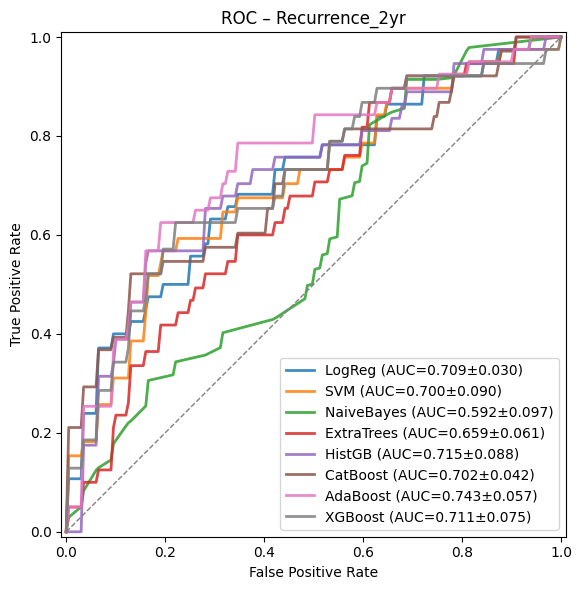

In [59]:
# ╔═╡ Cell 7 – Plot combined ROC figure without Ensemble ══════════════════════╗
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for idx, disp in enumerate(roc_displays):
    # skip the placeholder Ensemble curve
    if "Ensemble" in disp.estimator_name:
        continue

    disp.plot(
        ax=plt.gca(),
        alpha=0.85,
        linewidth=2,
        color=colors[idx % len(colors)]
    )

plt.plot([0, 1], [0, 1], "--", color="grey", linewidth=1)
plt.title("ROC – Recurrence_2yr")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


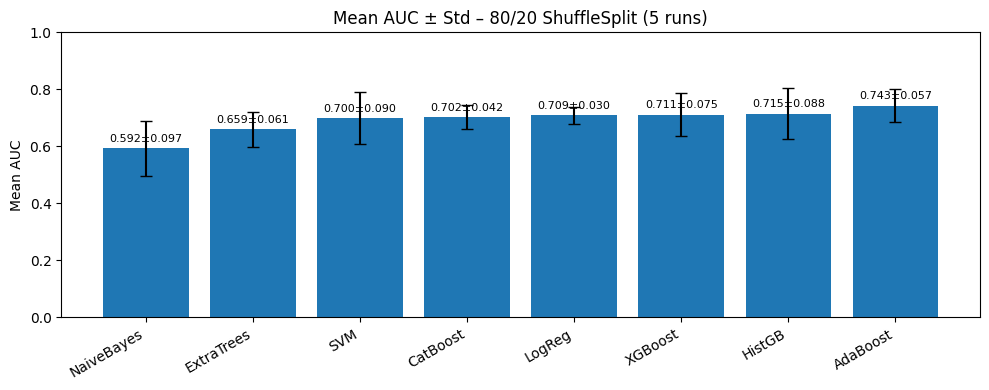

In [63]:
# ╔═╡ Cell 8 – Bar chart of mean ShuffleSplit AUCs with ±std ─════════╗
import numpy as np

# 1. Compute mean & std per model
mean_aucs = {name: np.mean(vals) for name, vals in aucs.items()}
std_aucs  = {name: np.std(vals)  for name, vals in aucs.items()}

# 2. Sort by mean AUC
sorted_items = sorted(mean_aucs.items(), key=lambda kv: kv[1])
labels, means = zip(*sorted_items)
stds = [std_aucs[name] for name in labels]

# 3. Plot bars with error bars
plt.figure(figsize=(10, 4))
bars = plt.bar(labels, means, yerr=stds, capsize=4)
plt.ylim(0, 1)
plt.ylabel("Mean AUC")
plt.title("Mean AUC ± Std – 80/20 ShuffleSplit (5 runs)")
plt.xticks(rotation=30, ha="right")

# 4. Annotate each bar with mean±std
for bar, m, s in zip(bars, means, stds):
    text = f"{m:.3f}±{s:.3f}"
    plt.annotate(
        text,
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3), textcoords="offset points",
        ha="center", va="bottom", fontsize=8
    )

plt.tight_layout()
plt.show()


In [65]:
# ╔═╡ Cell 9 – Quick summary table with mean ± std AUC (excluding Ensemble) ═══════════╗
import numpy as np
import pandas as pd

# Build a list of records, skipping the Ensemble placeholder
records = []
for name, vals in aucs.items():
    if name == "Ensemble":
        continue
    records.append({
        "Model":    name,
        "Mean AUC": np.mean(vals),
        "Std AUC":  np.std(vals)
    })

# Create DataFrame and sort
summary = (
    pd.DataFrame(records)
      .sort_values("Mean AUC", ascending=False)
      .reset_index(drop=True)
)

# Plain-text print
print(summary.to_string(index=False, float_format="%.3f"))


     Model  Mean AUC  Std AUC
  AdaBoost     0.743    0.057
    HistGB     0.715    0.088
   XGBoost     0.711    0.075
    LogReg     0.709    0.030
  CatBoost     0.702    0.042
       SVM     0.700    0.090
ExtraTrees     0.659    0.061
NaiveBayes     0.592    0.097


In [66]:
# ╔═╡ Cell 10.0 – Bootstrap AUC with 95% CI on the hold-out set ─────────────────╗
import numpy as np
from sklearn.metrics import roc_auc_score

# 1) Ground truth & predicted probabilities on hold-out
y_true = y_hold.reset_index(drop=True)
X_eval = X_hold.reset_index(drop=True)
y_prob = models["XGBoost"].predict_proba(X_eval)[:, 1]

# 2) Bootstrap settings
n_bootstraps = 1000
rng = np.random.RandomState(42)
boot_scores = []

# 3) Draw bootstrap samples and compute AUC
for _ in range(n_bootstraps):
    idxs = rng.choice(len(y_true), size=len(y_true), replace=True)
    y_samp = y_true.iloc[idxs]
    p_samp = y_prob[idxs]
    # skip if only one class in sample
    if y_samp.nunique() < 2:
        continue
    boot_scores.append(roc_auc_score(y_samp, p_samp))

# 4) Aggregate results
auc_mean   = roc_auc_score(y_true, y_prob)
ci_lower, ci_upper = np.percentile(boot_scores, [2.5, 97.5])

# 5) Report
print(f"Hold-out AUC           = {auc_mean:.3f}")
print(f"95% CI (bootstrap) = [{ci_lower:.3f}, {ci_upper:.3f}]")


Hold-out AUC           = 0.602
95% CI (bootstrap) = [0.465, 0.747]


In [67]:
# ╔═╡ Cell 10.1 – Pipeline + sigmoid calibration ─────────────────────╗
from sklearn.pipeline            import Pipeline
from sklearn.calibration        import CalibratedClassifierCV
from xgboost                    import XGBClassifier

# 1) Build an XGB pipeline WITHOUT early stopping
#    This uses the same hyperparameters you found in Cell 5.4 (best_params).
xgb_pipe_uncal = Pipeline([
    ("prep", pre_xgb),  # your simple median‐imputer + ordinal‐encoder ColumnTransformer
    ("clf",  XGBClassifier(
        **best_params,               # from your RandomizedSearchCV in Cell 5.4
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        random_state=RANDOM_STATE
        # <— NO early_stopping_rounds here!
    ))
])

# 2) Wrap in a Platt‐scaler (sigmoid) using 5‐fold CV on the full training set
calibrator = CalibratedClassifierCV(
    estimator=xgb_pipe_uncal,
    method="sigmoid",  # Platt scaling
    cv=5
)

# 3) Fit on your entire training set
calibrator.fit(X_train, y_train)

# 4) Store back into your models dict
models["XGBoost_Calibrated"] = calibrator

print("✅ Calibrated XGBoost fitted with sigmoid scaling (5‐fold CV).")


✅ Calibrated XGBoost fitted with sigmoid scaling (5‐fold CV).


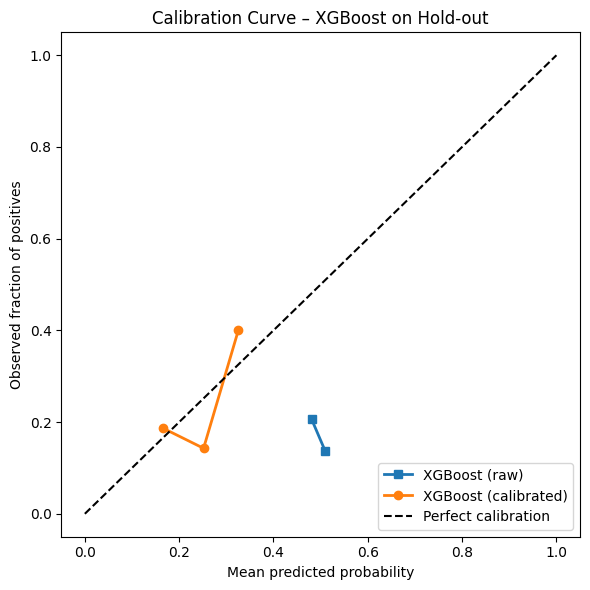

Brier score (raw)        = 0.2417
Brier score (calibrated) = 0.1509


In [69]:
# ╔═╡ Cell 10.2 – Calibration curve + Brier score on the hold‐out set ─────────────╢
from sklearn.calibration import calibration_curve
from sklearn.metrics      import brier_score_loss
import matplotlib.pyplot as plt

# 1) Ground truth & predicted probabilities on hold‐out
y_true      = y_hold.reset_index(drop=True)
X_eval      = X_hold.reset_index(drop=True)
y_prob_raw  = models["XGBoost"]           .predict_proba(X_eval)[:, 1]
y_prob_cal  = models["XGBoost_Calibrated"].predict_proba(X_eval)[:, 1]

# 2) Compute calibration curves
#    - using uniform bins ensures equal-width probability intervals
frac_pos_raw, mean_pred_raw = calibration_curve(
    y_true, y_prob_raw, n_bins=10, strategy="uniform"
)
frac_pos_cal, mean_pred_cal = calibration_curve(
    y_true, y_prob_cal, n_bins=10, strategy="uniform"
)

# 3) Plot
plt.figure(figsize=(6, 6))
plt.plot(mean_pred_raw, frac_pos_raw, marker="s", linewidth=2, label="XGBoost (raw)")
plt.plot(mean_pred_cal, frac_pos_cal, marker="o", linewidth=2, label="XGBoost (calibrated)")
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed fraction of positives")
plt.title("Calibration Curve – XGBoost on Hold-out")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 4) Brier scores
bs_raw = brier_score_loss(y_true, y_prob_raw)
bs_cal = brier_score_loss(y_true, y_prob_cal)
print(f"Brier score (raw)        = {bs_raw:.4f}")
print(f"Brier score (calibrated) = {bs_cal:.4f}")


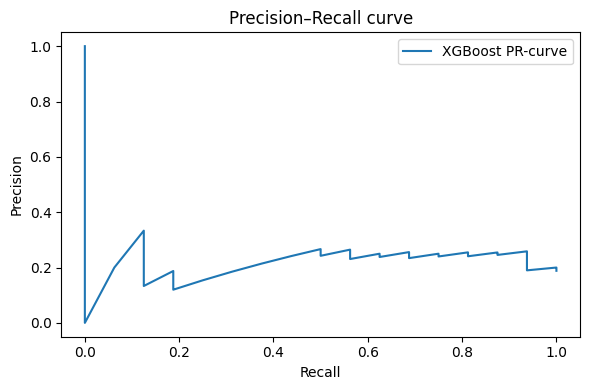

Best F1=0.405 at threshold=0.48


In [73]:
# ╔═╡ Cell 10.3 – Precision–Recall & threshold‐tuning ════════════════╗
from sklearn.metrics import precision_recall_curve, f1_score

y_prob = models["XGBoost"].predict_proba(X_hold)[:,1]
precision, recall, thresholds = precision_recall_curve(y_hold, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="XGBoost PR-curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()
plt.tight_layout()
plt.show()

# F1 vs threshold
f1s = [f1_score(y_hold, y_prob>=t) for t in thresholds]
opt_idx = np.argmax(f1s)
print(f"Best F1={f1s[opt_idx]:.3f} at threshold={thresholds[opt_idx]:.2f}")


In [ ]:
# ╔═╡ Cell 10.4 – Model-agnostic SHAP (Calibrated XGBoost + KernelExplainer) ─────────╗
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 0) Unpack your sigmoid-calibrated XGBoost pipeline
calibrator = models["XGBoost_Calibrated"]

# 1) Grab feature names for round-tripping arrays → DataFrame
feature_names = X_train.columns.tolist()

# 2) Build a wrapper that accepts either np.ndarray or pd.DataFrame
def model_proba(arr_or_df):
    # if KernelExplainer passes in a plain array, turn it into a DF
    if isinstance(arr_or_df, np.ndarray):
        df = pd.DataFrame(arr_or_df, columns=feature_names)
    else:
        df = arr_or_df
    return calibrator.predict_proba(df)[:, 1]

# 3) Draw a small background sample (NumPy) for Kernel SHAP
bg = shap.sample(X_train, 100, random_state=RANDOM_STATE).values

# 4) Instantiate a fully model-agnostic explainer
explainer_agn = shap.KernelExplainer(
    model_proba,
    bg
)

# 5) Compute SHAP values on your held-out test set (as an array)
shap_values_agn = explainer_agn.shap_values(
    X_test.values,
    nsamples=200      # lower this if it’s too slow
)

# 6) Compute global min/max & add 10% margin for clear x-axis
sv = np.array(shap_values_agn)
lo, hi   = sv.min(), sv.max()
margin   = 0.1 * (hi - lo)

# 7) Beeswarm (dot) summary on probability scale
plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_values_agn,
    X_test.values,
    feature_names=feature_names,
    plot_type="dot",
    max_display=20,
    show=False
)
plt.xlim(lo - margin, hi + margin)
plt.title("SHAP Beeswarm – Calibrated XGBoost (Recurrence_2yr)")
plt.tight_layout()
plt.show()

# 8) Bar plot of mean(|SHAP|)
plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_values_agn,
    X_test.values,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("mean(|SHAP|) – Calibrated XGBoost")
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 10.5 – Partial dependence for top features (Calibrated XGBoost) ═════════╗
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 0) Unpack your calibrated XGBoost pipeline
calibrator = models["XGBoost_Calibrated"]

# 1) Grab the SHAP values array you computed in Cell 10.4
#    shap_values_agn may be a list [class0_vals, class1_vals] or a 2D array already
if isinstance(shap_values_agn, list):
    # pick the positive‐class contributions
    vals = np.array(shap_values_agn[1])
else:
    vals = np.array(shap_values_agn)

# 2) Compute mean(|SHAP|) per feature and pick the top 3
importances = np.abs(vals).mean(axis=0)
top_idx    = np.argsort(importances)[::-1][:3]
top_feats  = [X_test.columns[i] for i in top_idx]
print("Top 3 features by |SHAP|:", top_feats)

# 3) Plot partial dependence of those top 3 on the calibrated model
fig, axes = plt.subplots(1, len(top_feats), figsize=(4 * len(top_feats), 4))
PartialDependenceDisplay.from_estimator(
    calibrator,
    X_test,
    features=top_feats,
    kind="average",
    ax=axes
)
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 10.6 – Permutation importance ══════════════════════════╗
from sklearn.inspection import permutation_importance

r = permutation_importance(
    models["XGBoost"], X_test, y_test,
    scoring="roc_auc", n_repeats=10, random_state=RANDOM_STATE
)
perm_df = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_df.head(10).plot.barh()
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation importance – XGBoost")
plt.tight_layout()
plt.show()

In [ ]:
# ╔═╡ Cell 10.7 – Manual Decision Curve Analysis (Net Benefit) ─════════════╗
import numpy as np
import matplotlib.pyplot as plt

# 1) True labels & predicted probabilities (from your best model)
y_true = y_test.values        # shape (n_samples,)
y_prob = models["XGBoost"].predict_proba(X_test)[:,1]

N      = len(y_true)
preval = y_true.mean()        # event rate

# 2) Define a grid of thresholds
thresholds = np.linspace(0.01, 0.99, 99)

# 3) Compute net benefit for each threshold
nb_model = []
nb_all   = []
nb_none  = np.zeros_like(thresholds)

for pt in thresholds:
    preds = (y_prob >= pt).astype(int)
    TP    = ((preds == 1) & (y_true == 1)).sum()
    FP    = ((preds == 1) & (y_true == 0)).sum()
    # NB = TP/N - FP/N * (pt/(1-pt))
    nb    = TP/N - FP/N * (pt/(1-pt))
    nb_model.append(nb)
    nb_all.append(preval - (1 - preval)*(pt/(1-pt)))

# 4) Plot
plt.figure(figsize=(7,5))
plt.plot(thresholds, nb_model, label="XGBoost")
plt.plot(thresholds, nb_all,   label="Treat All",    linestyle="--")
plt.plot(thresholds, nb_none,  label="Treat None",   linestyle=":")
plt.xlabel("Decision Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis – Recurrence_2yr")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 10.8 – Final evaluation on future hold‐out ═══════════════════╗
from sklearn.metrics       import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    brier_score_loss,
    roc_curve
)
from sklearn.calibration   import calibration_curve
import matplotlib.pyplot   as plt
import numpy              as np

# 1) Pick your final model
best_model    = models["XGBoost"]    # or "XGBoost_Calibrated"
X_val, y_val  = X_test, y_test

# 2) Predicted probabilities & hard labels
y_val_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred  = best_model.predict(X_val)

# 3) Print metrics
print("Final AUC:            ", roc_auc_score(y_val, y_val_proba))
print("Confusion matrix (0.5):\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification report:\n", classification_report(y_val, y_val_pred))

# 4) ROC curve
RocCurveDisplay.from_predictions(y_val, y_val_proba)
plt.title("Final ROC on hold‐out")
plt.tight_layout()
plt.show()

# 5) Calibration curve & Brier score
frac_pos, mean_pred = calibration_curve(y_val, y_val_proba, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(mean_pred, frac_pos, "o-", label="XGB hold‐out")
plt.plot([0, 1], [0, 1], "k--",  label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve – hold‐out")
plt.legend()
plt.tight_layout()
plt.show()

print("Final Brier score:", brier_score_loss(y_val, y_val_proba))

# 6) Optimal threshold via Youden’s J
fpr, tpr, thresh = roc_curve(y_val, y_val_proba)
j_scores         = tpr - fpr
best_thresh      = thresh[np.argmax(j_scores)]
print(f"Optimal threshold (max Youden's J): {best_thresh:.3f}")


In [ ]:
# ╔═╡ Cell 10.9 – Bootstrap‐Calibrated XGBoost on future hold‐out ═════════╗
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils           import resample
from sklearn.base            import clone
from sklearn.metrics         import (
    roc_auc_score, roc_curve,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    brier_score_loss
)
from sklearn.calibration     import CalibratedClassifierCV

# 1) Number of bootstrap replicates
n_boot = 20

# 2) Prepare array to hold each replicate’s hold‐out probs
boot_preds = np.zeros((len(X_test), n_boot))

# 3) Loop: bootstrap sample → clone uncalibrated pipeline → calibrate → predict
for i in range(n_boot):
    # a) draw a bootstrap sample from your build set
    Xb, yb = resample(X_train, y_train, random_state=RANDOM_STATE + i)
    # b) clone the UNCALIBRATED XGB pipeline you built in Cell 10.1
    xgb_pipe = clone(xgb_pipe_uncal)  # <-- no early stopping here!
    # c) wrap in a Platt‐scaler (sigmoid) calibrator
    calib = CalibratedClassifierCV(
        estimator=xgb_pipe,
        method="sigmoid",
        cv=3
    )
    # d) fit on the bootstrap draw
    calib.fit(Xb, yb)
    # e) predict probabilities on the true 20% hold‐out
    boot_preds[:, i] = calib.predict_proba(X_test)[:, 1]

# 4) average the bootstrap‐calibrated probabilities
y_mean = boot_preds.mean(axis=1)
y_pred = (y_mean >= 0.5).astype(int)

# 5) Discrimination & classification metrics
print("Bootstrap‐Calibrated XGBoost AUC:   ",
      roc_auc_score(y_test, y_mean))
print("Confusion matrix @0.5:\n",
      confusion_matrix(y_test, y_pred))
print("\nClassification report:\n",
      classification_report(y_test, y_pred))

# 6) Plot ROC
RocCurveDisplay.from_predictions(y_test, y_mean)
plt.title("Bootstrap‐Calibrated XGBoost – ROC on hold‐out")
plt.tight_layout()
plt.show()

# 7) Calibration curve + Brier score
from sklearn.calibration import calibration_curve
frac_pos, mean_pred = calibration_curve(y_test, y_mean, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(mean_pred, frac_pos, "o-", label="Boot‐Calibrated XGB")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve – hold‐out")
plt.legend()
plt.tight_layout()
plt.show()

print("Bootstrap‐Calibrated XGB Brier score:",
      brier_score_loss(y_test, y_mean))

# 8) Optimal threshold via Youden’s J
fpr, tpr, thresh = roc_curve(y_test, y_mean)
j_scores       = tpr - fpr
best_thresh    = thresh[np.argmax(j_scores)]
print(f"Optimal threshold (max Youden’s J): {best_thresh:.3f}")


In [ ]:
# ╔═╡ Cell 11.0 – SHAP summary for CatBoost (Recurrence_2yr) ─════════════╗
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1) Unpack the bare CatBoostClassifier
if hasattr(models["CatBoost"], "named_steps"):
    cb_model = models["CatBoost"].named_steps["clf"]
else:
    cb_model = models["CatBoost"]

# 2) Prepare DataFrames exactly as CatBoost saw them
X_train_cb = prepare_for_catboost(X_train, cat)
X_test_cb  = prepare_for_catboost(X_test,  cat)

# 3) Build a SHAP TreeExplainer without background data, using tree_path_dependent
explainer_cb = shap.TreeExplainer(
    cb_model,
    feature_perturbation="tree_path_dependent"
)

# 4) Compute SHAP values for the positive class
shap_values_cb = explainer_cb.shap_values(X_test_cb)
print("🔎 SHAP values shape:", np.array(shap_values_cb).shape)

# 5) Determine global min/max of SHAP values and add a 10% margin
sv = np.array(shap_values_cb)
lo, hi = sv.min(), sv.max()
margin = 0.1 * (hi - lo)

plt.figure(figsize=(16, 5))
shap.summary_plot(
    shap_values_cb,
    X_test_cb,
    plot_type="dot",
    max_display=20,
    show=False
)

# now expand the x‐axis
plt.xlim(lo - margin, hi + margin)
plt.title("SHAP Beeswarm – CatBoost (Recurrence_2yr)")
plt.tight_layout()
plt.show()

# 7) (Optional) You can still generate the bar summary afterwards:
plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_values_cb,
    X_test_cb,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("mean(|SHAP|) – CatBoost")
plt.tight_layout()
plt.show()

In [ ]:
# ╔═╡ Cell 11.1 – Manual Partial Dependence (top 3 CatBoost features) ═══════╗
import numpy as np
import matplotlib.pyplot as plt

# 1) Unpack your CatBoost model
cb_entry = models["CatBoost"]
if hasattr(cb_entry, "named_steps"):
    cb_model = cb_entry.named_steps["clf"]
else:
    cb_model = cb_entry

# 2) Prepare the raw DataFrame exactly as for SHAP
X_cb = prepare_for_catboost(X_train, cat)

# 3) Identify top-3 features by mean(|SHAP|):
feat_names    = X_cb.columns.tolist()
mean_abs_shap = np.abs(shap_values_cb).mean(axis=0)
top3_idx      = np.argsort(mean_abs_shap)[-3:]
top3_feats    = [feat_names[i] for i in top3_idx]

# 4) Compute & plot partial dependence manually
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, feat in zip(axes, top3_feats):
    grid = np.linspace(X_cb[feat].min(), X_cb[feat].max(), 50)
    pdp  = []
    for val in grid:
        X_temp = X_cb.copy()
        X_temp[feat] = val
        preds = cb_model.predict_proba(X_temp)[:, 1]
        pdp.append(preds.mean())
    ax.plot(grid, pdp, linewidth=2)
    ax.set_xlabel(feat)
    ax.set_ylabel("Predicted P(recurrence)")
    ax.set_title(feat)
plt.suptitle("Partial Dependence – CatBoost (top 3 features)", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 11.2 – Manual permutation importance (CatBoost) ─════════════╗
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# 1) Unpack the raw CatBoostClassifier
cb_entry = models["CatBoost"]
if hasattr(cb_entry, "named_steps"):
    cb_model = cb_entry.named_steps["clf"]
else:
    cb_model = cb_entry

# 2) Prepare your test DataFrame exactly as for training
X_test_cb = prepare_for_catboost(X_test, cat)
y_test_arr = y_test.values

# 3) Compute baseline AUC
baseline_auc = roc_auc_score(y_test_arr, cb_model.predict_proba(X_test_cb)[:,1])

# 4) Permute each feature and record AUC drop
features = cont + cat
n_repeats = 20
rng = np.random.RandomState(RANDOM_STATE)

importances = []
for feat in features:
    drops = []
    for _ in range(n_repeats):
        X_perm = X_test_cb.copy()
        X_perm[feat] = rng.permutation(X_perm[feat].values)
        perm_auc = roc_auc_score(y_test_arr, cb_model.predict_proba(X_perm)[:,1])
        drops.append(baseline_auc - perm_auc)
    importances.append(np.mean(drops))

# 5) Build DataFrame and plot top 20
imp_df = pd.DataFrame({
    "feature": features,
    "mean_decrease_auc": importances
}).sort_values("mean_decrease_auc", ascending=False).head(20)

plt.figure(figsize=(6, 8))
plt.barh(imp_df["feature"][::-1], imp_df["mean_decrease_auc"][::-1])
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation importance – CatBoost")
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 11.3 – Decision curve (CatBoost) ─────────────────────────────╗
import numpy as np
import matplotlib.pyplot as plt

# 1) Grab your CatBoostClassifier (bare or inside a Pipeline)
cb_obj = models["CatBoost"]
if hasattr(cb_obj, "named_steps"):
    # If you ever wrapped CatBoost in a SkPipeline/ImbPipeline:
    cb_model = cb_obj.named_steps["clf"]
else:
    cb_model = cb_obj

# 2) Prepare the raw DataFrame exactly as you did for SHAP
X_test_cb = prepare_for_catboost(X_test, cat)

# 3) Get predicted probabilities for the positive class
probs = cb_model.predict_proba(X_test_cb)[:, 1]

# 4) Build “net benefit” curve
thresholds = np.linspace(0, 1, 100)
n          = len(y_test)
event_rate = y_test.mean()

nb = []
for t in thresholds:
    tp = ((probs >= t) & (y_test == 1)).sum()
    fp = ((probs >= t) & (y_test == 0)).sum()
    nb.append(tp/n - fp/n * (t/(1-t)))

# 5) Plot
plt.figure(figsize=(6, 4))
plt.plot(thresholds, nb, label="CatBoost")
plt.plot(thresholds, np.zeros_like(thresholds), "--", label="Treat none")
plt.plot(
    thresholds,
    event_rate - (1-event_rate)*(thresholds/(1-thresholds)),
    ":", label="Treat all"
)
plt.xlabel("Decision threshold")
plt.ylabel("Net benefit")
plt.title("Decision Curve Analysis – CatBoost")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 11.4 – Final evaluation on future hold-out for CatBoost (fixed) ─════╗
from sklearn.metrics           import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    roc_curve
)
from sklearn.calibration       import calibration_curve
from sklearn.metrics           import brier_score_loss
import matplotlib.pyplot as plt
import numpy as np

# 1) Unpack your CatBoostClassifier (raw or inside a pipeline)
cb_entry = models["CatBoost"]
if hasattr(cb_entry, "named_steps"):
    # you wrapped CatBoost in a Pipeline(prep→clf)
    clf = cb_entry.named_steps["clf"]
else:
    # you stored the bare CatBoostClassifier
    clf = cb_entry

# 2) Prepare your test‐set exactly as at train‐time
X_val_cb = prepare_for_catboost(X_test, cat)
y_val    = y_test.values

# 3) Predict
y_val_proba = clf.predict_proba(X_val_cb)[:, 1]
y_val_pred  = (y_val_proba >= 0.5).astype(int)

# 4) Discrimination & classification metrics
print("CatBoost AUC:           ", roc_auc_score(y_val, y_val_proba))
print("CatBoost Confusion @0.5:\n", confusion_matrix(y_val, y_val_pred))
print("\nCatBoost Classification report:\n",
      classification_report(y_val, y_val_pred))

# 5) ROC curve
RocCurveDisplay.from_predictions(y_val, y_val_proba)
plt.title("CatBoost – ROC on hold-out")
plt.tight_layout()
plt.show()

# 6) Calibration curve + Brier score
frac_pos, mean_pred = calibration_curve(y_val, y_val_proba, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(mean_pred, frac_pos, "o-", label="CatBoost hold-out")
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("CatBoost – Calibration on hold-out")
plt.legend()
plt.tight_layout()
plt.show()

print("CatBoost Brier score:", brier_score_loss(y_val, y_val_proba))

# 7) Optimal threshold via Youden’s J
fpr_cb, tpr_cb, thr_cb = roc_curve(y_val, y_val_proba)
j_scores_cb = tpr_cb - fpr_cb
best_thresh = thr_cb[np.argmax(j_scores_cb)]
print(f"CatBoost optimal threshold (max J): {best_thresh:.3f}")


In [ ]:
# ╔═╡ Cell 11.5 – Calibrate your CatBoost on the build set ═════════════╗
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline    import Pipeline

# a) unpack your existing prep→clf
cb_pipe = models["CatBoost"]
if hasattr(cb_pipe, "named_steps"):
    prep = cb_pipe.named_steps["prep"]
    base = cb_pipe.named_steps["clf"]
else:
    prep = preprocessor
    base = cb_pipe

# b) build a small Pipeline with isotonic (or sigmoid) calibration
calibrated_cb = Pipeline([
    ("prep", prep),
    ("cal",  CalibratedClassifierCV(
                 estimator=base,     # <— use 'estimator', not 'base_estimator'
                 method="isotonic",  # or 'sigmoid'
                 cv=3
             ))
])

# c) fit only on your 80% build data
calibrated_cb.fit(X_train, y_train)

# d) swap into your models dict
models["CatBoost_Calibrated"] = calibrated_cb

print("✅ CatBoost_Calibrated added to models dict")


In [ ]:
# ╔═╡ Cell 11.6 – Bootstrap‐ensemble for CatBoost (fixed) ─════════════╗
from sklearn.utils     import resample
from sklearn.metrics   import roc_auc_score
from catboost          import CatBoostClassifier
import numpy as np

# unpack your pipeline
cb_entry = models["CatBoost"]
if hasattr(cb_entry, "named_steps"):
    prep     = cb_entry.named_steps["prep"]
    base_cb  = cb_entry.named_steps["clf"]
else:
    prep     = preprocessor
    base_cb  = cb_entry

n_boot = 10
boot_preds = np.zeros((len(X_test), n_boot))

for i in range(n_boot):
    # 1) bootstrap‐resample the raw DataFrame + labels
    Xb_df, yb = resample(X_train, y_train, random_state=RANDOM_STATE + i)
    # 2) prepare_for_catboost (fills NaNs, casts cats to str)
    Xb_cb = prepare_for_catboost(Xb_df, cat)
    Xtest_cb = prepare_for_catboost(X_test, cat)
    # 3) clone the CatBoost with identical hyperparams
    cb = CatBoostClassifier(**base_cb.get_params())
    # 4) fit on the DataFrame (CatBoost will handle numeric & string cats)
    cb.fit(
      Xb_cb, yb,
      cat_features=cat_features_idx,
      verbose=False
    )
    # 5) predict on your hold‐out DataFrame
    boot_preds[:, i] = cb.predict_proba(Xtest_cb)[:, 1]

# aggregate
y_mean = boot_preds.mean(axis=1)
print("Bootstrapped CatBoost AUC:", roc_auc_score(y_test, y_mean))


In [ ]:
# ╔═╡ Cell 11.7 – Compare Calibrated vs Bootstrap CatBoost on future hold‐out ─══╗
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics       import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    brier_score_loss
)
from sklearn.calibration   import calibration_curve

# -------------------------------------------------------------------
# 1) Calibrated CatBoost evaluation
# -------------------------------------------------------------------
cal_cb = models["CatBoost_Calibrated"]
X_val, y_val = X_test, y_test

# predict
y_cal_proba = cal_cb.predict_proba(X_val)[:, 1]
y_cal_pred  = cal_cb.predict(X_val)

# metrics
print("=== Calibrated CatBoost on hold‐out ===")
print("AUC:           ", roc_auc_score(y_val, y_cal_proba))
print("Confusion @0.5:\n", confusion_matrix(y_val, y_cal_pred))
print(classification_report(y_val, y_cal_pred))

# ROC
RocCurveDisplay.from_predictions(y_val, y_cal_proba, name="Calibrated")
plt.title("Calibrated CatBoost – ROC")
plt.tight_layout()
plt.show()

# Calibration curve + Brier
frac_pos_c, mean_pred_c = calibration_curve(y_val, y_cal_proba, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(mean_pred_c, frac_pos_c, "o-", label="Calibrated")
plt.plot([0,1],[0,1],"k--", label="Ideal")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibrated CatBoost – Calibration")
plt.legend()
plt.tight_layout()
plt.show()

print("Brier score:", brier_score_loss(y_val, y_cal_proba))
print()

# -------------------------------------------------------------------
# 2) Bootstrap‐ensemble CatBoost evaluation (reuse boot_preds)
# -------------------------------------------------------------------
# `boot_preds` from Cell 11.6 has shape (n_test, n_boot)
y_boot_mean = boot_preds.mean(axis=1)

print("=== Bootstrap‐ensemble CatBoost on hold‐out ===")
print("AUC:           ", roc_auc_score(y_val, y_boot_mean))

# hard‐classify at 0.5
y_boot_pred = (y_boot_mean >= 0.5).astype(int)
print("Confusion @0.5:\n", confusion_matrix(y_val, y_boot_pred))
print(classification_report(y_val, y_boot_pred))

# ROC
RocCurveDisplay.from_predictions(y_val, y_boot_mean, name="Bootstrapped")
plt.title("Bootstrap CatBoost – ROC")
plt.tight_layout()
plt.show()

# Calibration curve + Brier
frac_pos_b, mean_pred_b = calibration_curve(y_val, y_boot_mean, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(mean_pred_b, frac_pos_b, "o-", label="Bootstrapped")
plt.plot([0,1],[0,1],"k--", label="Ideal")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Bootstrap CatBoost – Calibration")
plt.legend()
plt.tight_layout()
plt.show()

print("Brier score:", brier_score_loss(y_val, y_boot_mean))
